Import essential libraries

In [1]:
import gym
import time
import random
import numpy as np

from collections import deque

import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

We declare two function get_session and run_on_cpu. The first one uses cuda and we should allocate one fraction of memory otherwise it will allocate almost all available gpu. The second one is for running the operations in cpu only.

In [2]:
import tensorflow as tf
import keras.backend.tensorflow_backend as KTF


def get_session(gpu_fraction=0.3):
    
    num_threads = os.environ.get('OMP_NUM_THREADS')
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=gpu_fraction)

    if num_threads:
        return tf.Session(config=tf.ConfigProto(
            gpu_options=gpu_options, intra_op_parallelism_threads=num_threads))
    else:
        return tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

def run_on_cpu():

    config = tf.ConfigProto(
        device_count = {'GPU': 0}
    )
    return tf.Session(config=config)
    
KTF.set_session(get_session())

Using TensorFlow backend.


Load Breakout Atari Game - BreakoutDeterministic-v4 use the skip frame that DeepMind used

In [3]:
env = gym.make( 'BreakoutDeterministic-v4')

[2017-10-16 00:17:59,436] Making new env: BreakoutDeterministic-v4


Preprocess observation
<p>1) Resize image</p>
<p>2) Crop center image - do not keep score </p>
<p>3) Grayscale image - reduce the rgb space to grayscale, save space </p>

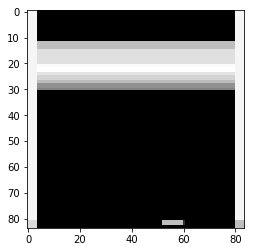

In [4]:
import cv2
import matplotlib.pyplot as plt

%matplotlib inline

def to_grayscale( observation ):
    r, g, b = observation[:,:,0], observation[:,:,1], observation[:,:,2]
    ret = 0.299 * r + 0.587 * g + 0.114 * b 
    return ( np.array( ret, dtype = np.uint8 ) )

def preprocess_observation( observation ):
    res = cv2.resize( observation, (84,110) )
    crop = res[18:110-8:,:,:]
    grayscale = to_grayscale( crop )
    return ( grayscale )

tmp = preprocess_observation( env.reset() )

plt.imshow( tmp, cmap='gray' )
plt.show()

Build model

Our model consists of:
    1 normalization layer - divide images by 255 which is the maximum value in grayscale images
    3 convolutional layers - relu activation function
    3 fully connected layers - relu activation function
    1 output layer - linear activation function

In [5]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Activation, Lambda
from keras.layers.convolutional import Conv2D
from keras.optimizers import RMSprop, Adam
from keras import initializers

# Build model

model = Sequential()

init_distr = initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)
#kernel_initializer=init_distr
#32 filters of kernel(3,3), stride=4, input shape must be in format row, col, channels
#init='uniform',

model.add( Lambda(lambda x: x / 255.0, dtype='float32',  input_shape=(84,84,4)) )

model.add( Conv2D(32, (8,8), strides=(4,4), padding='same' ) )
model.add( Activation( 'relu' ) )

model.add(Conv2D(64, (4,4), strides=(2,2), padding='same' ) )
model.add( Activation( 'relu' ) )

model.add(Conv2D(64, (3,3), strides=(1,1), padding='same' ) )
model.add( Activation( 'relu' ) )

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add( Dense( env.action_space.n, activation='linear' ) )
#model.compile(RMSprop(), 'MSE')
#model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
learning_rate = 1e-6#025
model.compile(loss='mse', optimizer=Adam(lr=learning_rate), metrics=['accuracy'] )

model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 84, 84, 4)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 21, 21, 32)        8224      
_________________________________________________________________
activation_1 (Activation)    (None, 21, 21, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        32832     
_________________________________________________________________
activation_2 (Activation)    (None, 11, 11, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 64)        36928     
_________________________________________________________________
activation_3 (Activation)    (None, 11, 11, 64)        0         
__________

In [6]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 84, 84, 4)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 21, 21, 32)        8224      
_________________________________________________________________
activation_1 (Activation)    (None, 21, 21, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        32832     
_________________________________________________________________
activation_2 (Activation)    (None, 11, 11, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 64)        36928     
_________________________________________________________________
activation_3 (Activation)    (None, 11, 11, 64)        0         
__________

Build fixed model - that we will update during training.
Afterwards we will update the weights when we save them on disk

In [ ]:
#build fixed
from keras.models import model_from_json

json_string = model.to_json()
fixed_model = model_from_json(json_string)#does not load weights
fixed_model.compile(loss='mse', optimizer=Adam(lr=learning_rate), metrics=['accuracy'] )

In [ ]:
import time

gamma = 0.99
alpha = 1#0.999999#00025

max_reward = 0.0

epoch = 0

start_episode = 1

epsilon = 1
epsilon_min = 0.1

exploration_steps = 1000000

#amount that we will reduce from epsilon each time we pick an action using our policy
epsilon_discount = ( epsilon - epsilon_min ) / exploration_steps

MAX_SIZE = 40000#capacity of deque
MIN_MIN_SIZE = 20000#min size for replay in order to start replay which trains our model
D = deque( maxlen=MAX_SIZE )#stores states that are used for during training

frames = 0#keeps total frames so far

def load_deque():
    global D
    pkl_file = open( 'mydeque.pkl', 'rb')
    D = pickle.load( pkl_file )
    pkl_file.close()

def save_deque():
    output = open( 'mydeque.pkl', 'wb' )
    pickle.dump( D, output )
    output.close()

def load_dqn_model():
    global model, fixed_model
    from keras.models import model_from_json
    # load json and create model
    json_file = open('model_background.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)
    # load weights into new model
    model.load_weights("model_background.h5")
    print("Loaded model from disk")
    #model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
    model.compile(loss='mse', optimizer=Adam(lr=learning_rate), metrics=['accuracy'] )

    # load json and create model
    json_file = open('model_background.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    fixed_model = model_from_json(loaded_model_json)
    # load weights into new model
    fixed_model.load_weights("model_background.h5")
    print("Loaded model from disk - loaded to fixed")
    #model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
    fixed_model.compile(loss='mse', optimizer=Adam(lr=learning_rate), metrics=['accuracy'] )

import pandas as pd
import pickle

episodes = []
rewards = []
epsilons = []
total_frames = []

def save_train():

    global episodes, rewards, epsilons, total_frames

    #save [episodes, rewards, epsilons ] to csv file
    d = {'episode': episodes, 'reward': rewards, 'epsilon': epsilons, 'total_frames': total_frames}
    df = pd.DataFrame(data=d, index=None)

    if not os.path.isfile('filename.csv'):
        df.to_csv('filename.csv',header ='column_names', index=None)
    else: # else it exists so append without writing the header
        df.to_csv('filename.csv',mode = 'a',header=False, index=None)

    episodes = []
    rewards = []
    epsilons = []
    total_frames = []

    #save model to disk
    # serialize model to JSON
    model_json = model.to_json()
    with open("model_background.json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights("model_background.h5")
    print("Saved model to disk")

    #save deque to disk
    #save_deque()

def load_train():

    global start_episode, epsilon, frames

    #get last episode and epsilon
    if not os.path.isfile('filename.csv'):
        start_episode, epsilon = 1, 1
    else: # else it exists so append without writing the header
        df = pd.read_csv( 'filename.csv')

        if len(df) == 0:
            start_episode, epsilon, frames = 1, 1, 0
        else:
            epsilon = list( df['epsilon'].tail(1) )[0]
            start_episode = list( df['episode'].tail(1) )[0] + 1
            frames = list( df['total_frames'].tail(1) )[0]

    if os.path.isfile('model_background.json'):
        load_dqn_model()

    #if os.path.isfile('mydeque.pkl'):
        #load_deque()

load_train()

#print( start_episode, epsilon )
#print( type( start_episode ) )
#print( type( epsilon ) )
#print( model.summary() )
#print( D )

total_observe = 12000#total_episodes - total games to play
MIN_SIZE = 32#size of the minibatch - sample 32 samples

observe_frame = 0

#before starting training, we have to collect some samples - this stage is called "observe"
def must_observe():
    return ( observe_frame < MIN_MIN_SIZE )

#replay trains our model
def replay( ):

    if len( D ) < MIN_MIN_SIZE:
        return

    #print( "sample" )

    samples = random.sample( D, MIN_SIZE )

    all_x = []
    all_y = []

    for sample in samples:

        observation, reward, done, new_observation, action = sample

        y = model.predict( observation.reshape(  ( 1, 84, 84, 4) ) )

        Q_next = model.predict( new_observation.reshape(  ( 1, 84, 84, 4) ) )

        reward = np.clip( reward, -1, 1 )

        if done:
            y[0,action] = reward
        else:
            y[0,action] = reward + gamma * ( np.max( Q_next[0]  ) )

        #print( y )

        neural_network_observation = observation.reshape(  ( 1, 84, 84, 4) )

        all_x.append( neural_network_observation )
        all_y.append( y )
        #model.fit( neural_network_observation, y, epochs=1, verbose=0 )
        #model.train_on_batch( neural_network_observation, y )

    all_x = np.array( all_x ).reshape( (MIN_SIZE,84,84,4) )
    all_y = np.array( all_y ).reshape( (MIN_SIZE,4) )

    #model.train_on_batch( all_x, all_y )
    fixed_model.fit(all_x, all_y, epochs=1, batch_size=MIN_SIZE, verbose=0)

    del all_x, all_y

start = time.time()

episode = start_episode

while episode <= total_observe:#3600*5):

    #start new game
    
    observation = env.reset()

    observation = preprocess_observation( observation )

    #build first state
    recent_frames = deque(maxlen=4)

    for i in range( 4 ):
        recent_frames.append( observation )

    total_reward = 0

    #print( episode )

    cur_lives = 5

    step = 0

    action = 0

    steps = 0

    #play untill the game ends
    while True:

        #env.render()

        stack_observation = np.stack(recent_frames,axis=0)

        if must_observe():
            observe_frame += 1

        if must_observe() == False:
            steps += 1

        #pick an random action or use our policy
        if random.uniform(0,1) < epsilon:
            action = env.action_space.sample()
        else:
            Q = model.predict( stack_observation.reshape(  ( 1, 84, 84, 4) ) )[0]
            action = np.argmax( Q )
        #step = 0

        #execute selected action
        new_observation, reward, done, info = env.step( action )

        #build next stacked state
        new_observation = preprocess_observation( new_observation )#apply preprocess

        next_recent_frames = recent_frames.copy()
        next_recent_frames.append( new_observation )
        next_new_observation = np.stack(next_recent_frames,axis=0)

        memory_reward = reward

        if info['ale.lives'] < cur_lives:
            cur_lives = info['ale.lives']
            memory_reward = -1

        #insert into deque - those samples are later used for training
        D.append( ( stack_observation, memory_reward, done, next_new_observation, action ) )

        total_reward += reward

        replay()#train model

        #if game is over
        if done:
            if must_observe() == False:
                episodes.append( episode )
                rewards.append( total_reward )
                epsilons.append( epsilon )
            D.append( ( stack_observation, -1, done, next_new_observation, action ) )
            break

        observation = new_observation

        recent_frames.append( observation )

        #we reduce the epsilon only when we have collected enough samples
        if must_observe() == False:
            epsilon = max( epsilon_min, epsilon - epsilon_discount )

    if must_observe() == False:
        frames += steps
        total_frames.append( frames )
        print( "Episode " + str(episode) + " | total reward := " + str(total_reward) + " | steps := " + str(steps) + " total frames := " + str(frames) + " | epsilon := " + str(epsilon) )
    else:
        print( "Observe total frames := " + str(observe_frame) )

    #weights are saved per 10 games, also progress is saved on disk
    if episode % 10 == 0 and episode > 1:
        if must_observe() == False:
            model.set_weights( fixed_model.get_weights() )
            save_train()

    if must_observe() == False:
        episode += 1

end = time.time()

print("total time is " + str( end - start ) )


Observe total frames := 173
Observe total frames := 400
Observe total frames := 569
Observe total frames := 756
Observe total frames := 889
Observe total frames := 1097
Observe total frames := 1247
Observe total frames := 1452
Observe total frames := 1695
Observe total frames := 1827
Observe total frames := 2010
Observe total frames := 2143
Observe total frames := 2403
Observe total frames := 2573
Observe total frames := 2719
Observe total frames := 2852
Observe total frames := 2992
Observe total frames := 3201
Observe total frames := 3338
Observe total frames := 3479
Observe total frames := 3682
Observe total frames := 3899
Observe total frames := 4037
Observe total frames := 4285
Observe total frames := 4415
Observe total frames := 4562
Observe total frames := 4712
Observe total frames := 4847
Observe total frames := 5025
Observe total frames := 5160
Observe total frames := 5297
Observe total frames := 5466
Observe total frames := 5695
Observe total frames := 5829
Observe total frame